In [128]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing

In [129]:
# transform a timeseries dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
            # put it all together
    agg = pd.concat(cols, axis=1)
        # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [130]:
# load the dataset
series = pd.read_csv('./ft.csv', header=0, index_col=0,encoding='GB2312')
values = series.iloc[:,0].values
values = values.reshape(-1,1)
# transform the timeseries data into supervised learning
values.shape

(10713, 1)

In [131]:
scaler = preprocessing.StandardScaler().fit(values)
values = scaler.transform(values)

In [132]:
train = series_to_supervised(values, n_in=30)
# split into input andoutput columns
trainX, trainy =train[:, :-1], train[:, -1].reshape(-1,1)
trainX.shape,trainy.shape

((10683, 30), (10683, 1))

In [133]:
trainX.shape,trainy.shape

((10683, 30), (10683, 1))

In [134]:
trainX[:5],trainy[:5]

(array([[-0.05379352, -0.06475081, -0.05217045,  0.01276114,  0.12111583,
          0.0833741 ,  0.02493541,  0.11015788,  0.26558788,  0.31509778,
          0.30941641,  0.21973019,  0.27289231,  0.22622309,  0.20714983,
          0.25422449,  0.31063404,  0.20512068,  0.27573364,  0.23109293,
          0.26112413,  0.28384961,  0.30373505,  0.19943866,  0.12152127,
          0.05943036, -0.01239958,  0.06795241,  0.03508117,  0.06511238],
        [-0.06475081, -0.05217045,  0.01276114,  0.12111583,  0.0833741 ,
          0.02493541,  0.11015788,  0.26558788,  0.31509778,  0.30941641,
          0.21973019,  0.27289231,  0.22622309,  0.20714983,  0.25422449,
          0.31063404,  0.20512068,  0.27573364,  0.23109293,  0.26112413,
          0.28384961,  0.30373505,  0.19943866,  0.12152127,  0.05943036,
         -0.01239958,  0.06795241,  0.03508117,  0.06511238,  0.10569414],
        [-0.05217045,  0.01276114,  0.12111583,  0.0833741 ,  0.02493541,
          0.11015788,  0.26558788,  

#  数据模块

In [135]:
class DiabetesDataset(Dataset):
    def __init__(self, x_, y_):
        self.len = x_.shape[0]
        self.x_data = torch.from_numpy(x_)
        # 这部很关键， 特征类型要求float类型
        self.x_data = self.x_data.float()
        self.y_data = torch.from_numpy(y_)
        self.y_data = self.y_data.float()
        

    def __getitem__(self, item):
        return self.x_data[item], self.y_data[item]

    def __len__(self):
        return self.len

In [136]:
dataset = DiabetesDataset(trainX, trainy)
train_loader = DataLoader(dataset=dataset, batch_size=512, shuffle=False)

# 网络结构

In [137]:
# input_size 输入特征的大小
# hidden_size 神经元模块额数量
# num_layer 几层隐藏层
# lstm默认输入的维度是 (seq_len,batch,feature)
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size = 1,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True
        )
        self.out = nn.Linear(in_features = 64,out_features = 1)

    def forward(self, x):
        output,(h_n,c_n) = self.lstm(x)
        out = self.out(output[:,-1,:])
        return out

In [138]:
device = torch.device('cuda')
model = LSTM().to(device)

# 训练

In [141]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [143]:
total_step = len(train_loader)
epochs = 100
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1,30,1)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #rint(outputs.shape,labels.shape)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0 :
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))

Epoch [1/100], Step [5/21], Loss: 0.0004
Epoch [1/100], Step [10/21], Loss: 0.0003
Epoch [1/100], Step [15/21], Loss: 0.0008
Epoch [1/100], Step [20/21], Loss: 0.0012
Epoch [2/100], Step [5/21], Loss: 0.0004
Epoch [2/100], Step [10/21], Loss: 0.0003
Epoch [2/100], Step [15/21], Loss: 0.0008
Epoch [2/100], Step [20/21], Loss: 0.0012
Epoch [3/100], Step [5/21], Loss: 0.0004
Epoch [3/100], Step [10/21], Loss: 0.0003
Epoch [3/100], Step [15/21], Loss: 0.0008
Epoch [3/100], Step [20/21], Loss: 0.0012
Epoch [4/100], Step [5/21], Loss: 0.0004
Epoch [4/100], Step [10/21], Loss: 0.0003
Epoch [4/100], Step [15/21], Loss: 0.0008
Epoch [4/100], Step [20/21], Loss: 0.0012
Epoch [5/100], Step [5/21], Loss: 0.0004
Epoch [5/100], Step [10/21], Loss: 0.0003
Epoch [5/100], Step [15/21], Loss: 0.0008
Epoch [5/100], Step [20/21], Loss: 0.0012
Epoch [6/100], Step [5/21], Loss: 0.0004
Epoch [6/100], Step [10/21], Loss: 0.0003
Epoch [6/100], Step [15/21], Loss: 0.0008
Epoch [6/100], Step [20/21], Loss: 0.001

Epoch [49/100], Step [15/21], Loss: 0.0008
Epoch [49/100], Step [20/21], Loss: 0.0012
Epoch [50/100], Step [5/21], Loss: 0.0004
Epoch [50/100], Step [10/21], Loss: 0.0003
Epoch [50/100], Step [15/21], Loss: 0.0008
Epoch [50/100], Step [20/21], Loss: 0.0011
Epoch [51/100], Step [5/21], Loss: 0.0004
Epoch [51/100], Step [10/21], Loss: 0.0003
Epoch [51/100], Step [15/21], Loss: 0.0008
Epoch [51/100], Step [20/21], Loss: 0.0011
Epoch [52/100], Step [5/21], Loss: 0.0004
Epoch [52/100], Step [10/21], Loss: 0.0003
Epoch [52/100], Step [15/21], Loss: 0.0008
Epoch [52/100], Step [20/21], Loss: 0.0011
Epoch [53/100], Step [5/21], Loss: 0.0004
Epoch [53/100], Step [10/21], Loss: 0.0003
Epoch [53/100], Step [15/21], Loss: 0.0008
Epoch [53/100], Step [20/21], Loss: 0.0011
Epoch [54/100], Step [5/21], Loss: 0.0004
Epoch [54/100], Step [10/21], Loss: 0.0003
Epoch [54/100], Step [15/21], Loss: 0.0008
Epoch [54/100], Step [20/21], Loss: 0.0011
Epoch [55/100], Step [5/21], Loss: 0.0004
Epoch [55/100], S

Epoch [97/100], Step [10/21], Loss: 0.0003
Epoch [97/100], Step [15/21], Loss: 0.0008
Epoch [97/100], Step [20/21], Loss: 0.0012
Epoch [98/100], Step [5/21], Loss: 0.0006
Epoch [98/100], Step [10/21], Loss: 0.0003
Epoch [98/100], Step [15/21], Loss: 0.0008
Epoch [98/100], Step [20/21], Loss: 0.0011
Epoch [99/100], Step [5/21], Loss: 0.0005
Epoch [99/100], Step [10/21], Loss: 0.0003
Epoch [99/100], Step [15/21], Loss: 0.0008
Epoch [99/100], Step [20/21], Loss: 0.0011
Epoch [100/100], Step [5/21], Loss: 0.0004
Epoch [100/100], Step [10/21], Loss: 0.0003
Epoch [100/100], Step [15/21], Loss: 0.0008
Epoch [100/100], Step [20/21], Loss: 0.0011


# 预测

In [152]:
predicted = model(torch.FloatTensor(trainX.reshape(-1,30,1)).to(device))

In [154]:
predicted.shape,trainy.shape

(torch.Size([10683, 1]), (10683, 1))

In [155]:
import matplotlib.pyplot as plt

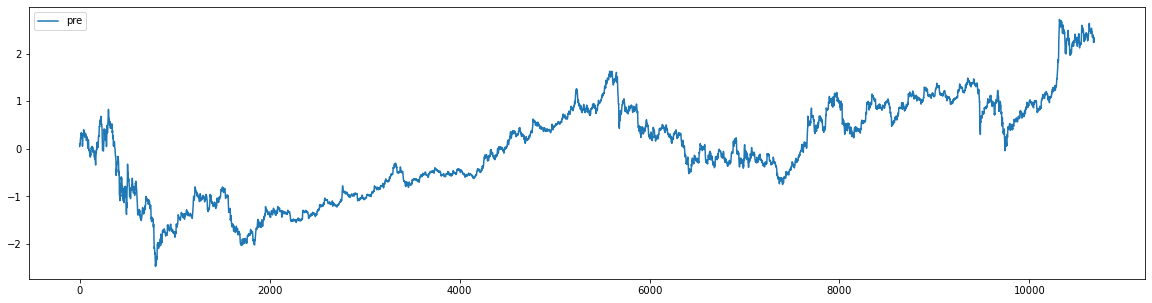

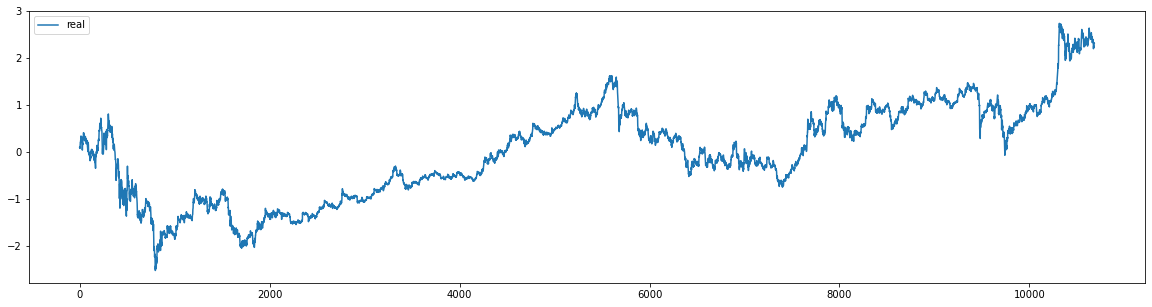

In [174]:
plt.figure(figsize=(20, 5))
plt.plot(predicted.cpu().detach().numpy(),label='pre')
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(20, 5))
plt.plot(trainy,label = 'real')
plt.legend(loc='best')

In [161]:
predicted.cpu().detach().numpy()

array([[0.04821348],
       [0.08661271],
       [0.09967358],
       ...,
       [2.27239   ],
       [2.3132393 ],
       [2.3263865 ]], dtype=float32)

In [162]:
trainy

array([[0.10569414],
       [0.10244736],
       [0.10123039],
       ...,
       [2.32141685],
       [2.31716587],
       [2.31822845]])

# 保存模型

In [175]:
path = './lst_ft.pth'
torch.save(model.state_dict(),path)